In [1]:
%matplotlib notebook
# starter code
import random
import numpy as np
from matplotlib import pyplot as plt
from tqdm import tqdm
import networkx as nx
from graph_tool.all import load_graph, shortest_distance, GraphView
from networkx.drawing.nx_agraph import graphviz_layout

from ic import simulate_cascade, observe_cascade, get_gvs, get_o2src_time, get_infection_time, gen_nontrivial_cascade
from utils import get_rank_index

seed = 123456
random.seed(seed)
np.random.seed(seed)

gtype = 'er'
g = load_graph('data/{}/2-6/graph.gt'.format(gtype))
gnx = nx.read_graphml('data/{}/2-6/graph.graphml'.format(gtype))
gnx = nx.relabel_nodes(gnx, {i: int(i) for i in gnx.nodes_iter()})
N1, N2 = 100, 100
p, q = 0.2, 0.2

gvs = get_gvs(g, p, N2)
pos = graphviz_layout(gnx, root=0)

In [2]:
from steiner_tree import sample_consistent_cascade, max_infection_time, best_tree_sizes

In [4]:
while True:
    infection_times, source, obs_nodes, true_tree = gen_nontrivial_cascade(g, p, q, return_tree=True)
    scores = best_tree_sizes(g, obs_nodes, infection_times)
    idx = get_rank_index(scores, source)
    if idx >= 10:
        break

In [7]:
from numpy.testing import assert_array_equal
remaining_nodes = set(np.arange(g.num_vertices())) - set(obs_nodes)
cs2gv = {}
for cand_source in tqdm(remaining_nodes):
    gv = sample_consistent_cascade(g, obs_nodes, cand_source, infection_times, debug=False)
    if gv is not None:
        cs2gv[cand_source] = gv

100%|██████████| 61/61 [00:00<00:00, 105.74it/s]


In [8]:
def extract_edges(gt_edges):
    return [(int(u), int(v)) for u, v in gt_edges]

In [9]:
print(len(cs2gv))

51


<IPython.core.display.Javascript object>


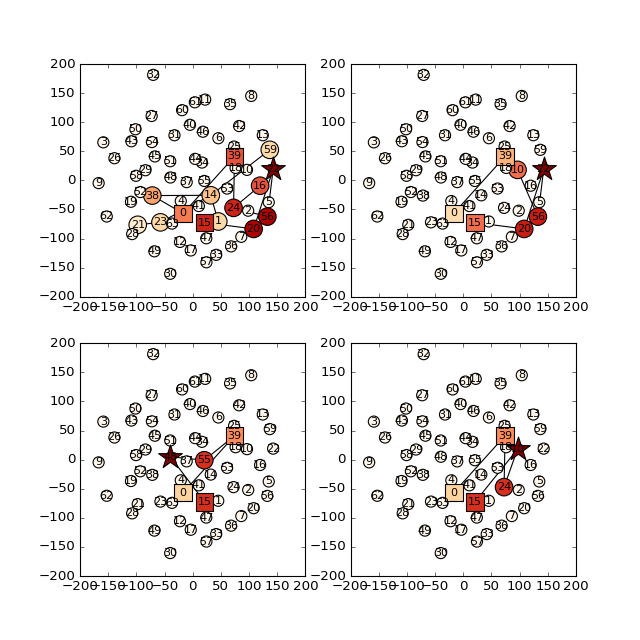

[37, 45, 46, 54, 62, 61, 60, 59, 58, 57, 56, 48]

In [11]:
from plot_utils import plot_snapshot
n1, n2 = np.argsort(scores)[::-1][:2]

fig, ax = plt.subplots(2, 2, figsize=(8, 8))
plot_snapshot(gnx, pos, infection_times, queried_nodes=obs_nodes, source_node=source, with_labels=True, ax=ax[0, 0],
             edges=extract_edges(true_tree.edges()))
plot_snapshot(gnx, pos, get_infection_time(cs2gv[source], source), queried_nodes=obs_nodes, source_node=source, with_labels=True,
              ax=ax[0, 1],
              edges=extract_edges(cs2gv[source].edges()))
plot_snapshot(gnx, pos, get_infection_time(cs2gv[n1], n1), queried_nodes=obs_nodes, source_node=n1, with_labels=True, ax=ax[1, 0],
              edges=extract_edges(cs2gv[n1].edges()))
plot_snapshot(gnx, pos, get_infection_time(cs2gv[n2], n2), queried_nodes=obs_nodes, source_node=n2, with_labels=True, ax=ax[1, 1],
              edges=extract_edges(cs2gv[n2].edges()))
[37, 45, 46, 54, 62, 61, 60, 59, 58, 57, 56, 48]

In [ ]:
sorted_cs = list(sorted(cs2gv, key=lambda cs: cs2gv[cs].num_edges()))
print([cs2gv[cs].num_edges() for cs in sorted_cs])
print(sorted_cs)
print(source)